In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.keras import Model, layers
import numpy as np
import pandas as pd
import pylab as plt
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
np.random.seed(2000)


In [2]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.keras.datasets import cifar10

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train / 255., x_test / 255.
y_train, y_test = np.reshape(y_train, [-1]), np.reshape(y_test, [-1])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
val_index, test_index = next(sss.split(x_test, y_test))
x_val, y_val, x_test, y_test = x_test[val_index], y_test[val_index], x_test[test_index], y_test[test_index]

### check Data
****

In [5]:
print(np.shape(x_train), np.shape(y_train), np.shape(x_val), np.shape(y_val), np.shape(x_test), np.shape(y_test))

(50000, 32, 32, 3) (50000,) (5000, 32, 32, 3) (5000,) (5000, 32, 32, 3) (5000,)


In [6]:
pd.DataFrame(y_train)[0].unique()

array([6, 9, 4, 1, 2, 7, 8, 3, 5, 0], dtype=uint8)

### Models and Functions
***

In [7]:
def cross_entropy_loss(logit_pred, label):
    # Convert labels to int 64 for tf cross-entropy function.
    label = tf.cast(label, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit_pred)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

def step_once(model, loss_f, x, y):
    with tf.GradientTape() as g:
        # Forward pass.
        pred = model.call(x, is_training=True)
        # Compute loss.
        loss = loss_f(pred, y)
        
    trainable_variables = model.trainable_variables

    # Compute gradients
    gradients = g.gradient(loss, trainable_variables)
    
    # Update weights
    optimizer.apply_gradients(zip(gradients, trainable_variables))

def optimize(model, optimizer, train_data, x_val, y_val, training_steps, loss_f=cross_entropy_loss, metric_f=accuracy, metric_name="accuracy", log_file="log.csv", model_file="nn.chkp"):
    best_loss = float("inf")
    log = pd.DataFrame(columns=['step', 'metric', 'value'])
    for i, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
        # Run the optimization to update W and b values.
        step_once(model, loss_f, batch_x, batch_y)

        if i % display_step == 0:
            pred = model(batch_x, is_training=True)
            loss = loss_f(pred, batch_y)
            metric = metric_f(pred, batch_y)
            pred_val = model(x_val, is_training=True)
            val_loss = loss_f(pred_val, y_val)
            metric_val = metric_f(pred_val, y_val)
            print("step: %i, loss: %f, %s: %f, Validation loss: %f, %s: %f" % (i, loss.numpy(), metric_name, metric.numpy(), val_loss.numpy(), metric_name, metric_val.numpy()))
            log = log.append({"step":i, "metric":"train_loss", "value": loss.numpy()}, ignore_index=True)
            log = log.append({"step":i, "metric":'train_' + metric_name, "value": metric.numpy()}, ignore_index=True)
            log = log.append({"step":i, "metric":"val_loss", "value": val_loss.numpy()}, ignore_index=True)
            log = log.append({"step":i, "metric":'val_' + metric_name, "value": metric_val.numpy()}, ignore_index=True)
            if(val_loss < best_loss):
                best_loss = val_loss
                model.save_weights(model_file)
    log.to_csv(log_file, index=False)

# Convolution neural network
****

In [9]:
class ConvNet(Model):
    # Set layers.
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu, padding='same')
        
        self.maxpool = layers.MaxPool2D(2, strides=2)

        self.conv2 = layers.Conv2D(128, kernel_size=3, activation=tf.nn.relu, padding='same')
        
        self.conv3 = layers.Conv2D(256, kernel_size=3, activation=tf.nn.relu, padding='same')
        
        self.conv4 = layers.Conv2D(512, kernel_size=3, activation=tf.nn.relu, padding='same')

        # Flatten the data to a 1-D vector for the fully connected layer.
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(256, activation=tf.nn.relu)
#         self.activation1 = tf.nn.relu(1024)
        self.fc2 = layers.Dense(128, activation=tf.nn.relu)
#         self.activation2 = tf.nn.relu(2048)
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout = layers.Dropout(rate=0.5)
#         self.bn = layers.bn()
        

        # Output layer, class prediction.
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 32, 32, 3])
#         plt.imshow(x[0], cmap='brg', aspect='auto')
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.maxpool(x)
#         x = self.conv4(x)
#         x = self.maxpool(x) 
        x = self.flatten(x)
        x = self.fc1(x)
#         x = self.activation1(x)
        x = self.dropout(x, training=is_training)
        x = self.fc2(x)
#         x = self.activation2(x)
        x = self.dropout(x, training=is_training)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build neural network model.
# conv_net = ConvNet()
# Data parameters
seed = 1000
num_classes = 10
num_features = 32 * 32 * 3

# Training parameters.
learning_rate = 0.2
training_steps = 5000
batch_size = 128
display_step = 200
prefetch = 1

model_file = 'models/cnn.chkp'
log_file = "logs/cnn.csv"
x_train, x_val, x_test = x_train.reshape([-1, num_features]), x_val.reshape([-1, num_features]), x_test.reshape([-1, num_features])

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(seed).batch(batch_size).prefetch(prefetch)

model = ConvNet(num_classes)

optimizer = tf.optimizers.SGD(learning_rate)

optimize(model, optimize, train_data, x_val, y_val, training_steps, loss_f=cross_entropy_loss, metric_f=accuracy, metric_name="accuracy", log_file=log_file, model_file=model_file)

step: 200, loss: 2.196365, accuracy: 0.187500, Validation loss: 2.200304, accuracy: 0.177000
step: 400, loss: 1.783988, accuracy: 0.390625, Validation loss: 1.819217, accuracy: 0.322000
step: 600, loss: 1.533186, accuracy: 0.429688, Validation loss: 1.640549, accuracy: 0.402000
step: 800, loss: 1.405798, accuracy: 0.570312, Validation loss: 1.555248, accuracy: 0.427400
step: 1000, loss: 1.288488, accuracy: 0.539062, Validation loss: 1.481574, accuracy: 0.467000
step: 1200, loss: 1.510052, accuracy: 0.468750, Validation loss: 1.528935, accuracy: 0.470600
step: 1400, loss: 1.077008, accuracy: 0.648438, Validation loss: 1.297327, accuracy: 0.541800
step: 1600, loss: 1.037406, accuracy: 0.625000, Validation loss: 1.220453, accuracy: 0.572400
step: 1800, loss: 1.090024, accuracy: 0.617188, Validation loss: 1.243214, accuracy: 0.573800
step: 2000, loss: 0.894257, accuracy: 0.664062, Validation loss: 1.130583, accuracy: 0.607800
step: 2200, loss: 0.848756, accuracy: 0.695312, Validation loss:

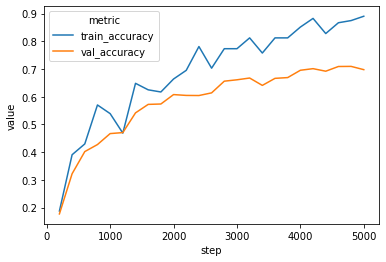

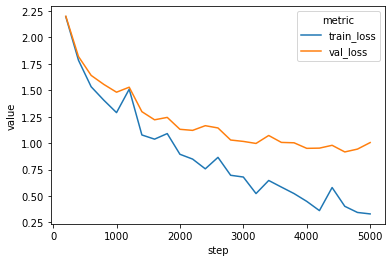

In [10]:
training_trajectory = pd.read_csv(log_file)
training_trajectory.head()
for x in set(map(lambda x: x.split('_')[1], training_trajectory['metric'].unique())):
    data = training_trajectory[training_trajectory['metric'].str.contains(x)]
    sns.lineplot(data=data, x='step', y='value', hue='metric')
    plt.show()

In [11]:
model = ConvNet(num_classes)
model.load_weights(model_file)
pred = model(x_test, is_training=False)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.742600


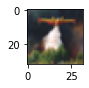

Model prediction: 5 dog, Correct: 0 airplane


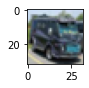

Model prediction: 1 car, Correct: 1 car


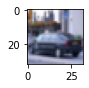

Model prediction: 1 car, Correct: 1 car


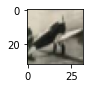

Model prediction: 0 airplane, Correct: 0 airplane


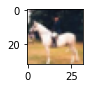

Model prediction: 7 horse, Correct: 7 horse


In [12]:
sample_size = 5
class_names = ['airplane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
test_images = x_test[:sample_size]
test_values = y_test[:sample_size]
predictions = model(test_images)

# Display image and model prediction.
for i in range(sample_size):
    plt.figure(figsize = (1,1))
    plt.imshow(np.reshape(test_images[i], [32, 32, 3]), cmap='brg', aspect='auto')
    plt.show()
    print("Model prediction: %i %s, Correct: %i %s" % (np.argmax(predictions.numpy()[i]), class_names[np.argmax(predictions.numpy()[i])], test_values[i], class_names[test_values[i]]))